Install seisbench using pip- ignore if already done

In [ ]:
!pip install seisbench

In [9]:
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import requests
import json
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import geopandas as gpd
import matplotlib.pyplot as plt
import seisbench
import seisbench.models as sbm

#### Get a list of which ML networks are available:

In [5]:
dir(sbm)

['BasicPhaseAE',
 'CRED',
 'DPPDetector',
 'DPPPicker',
 'DeepDenoiser',
 'DeepPhasePick',
 'EQTransformer',
 'GPD',
 'PhaseNet',
 'SeisBenchModel',
 'WaveformModel',
 'WaveformPipeline',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'aepicker',
 'base',
 'cred',
 'deepdenoiser',
 'dpp',
 'eqtransformer',
 'gpd',
 'phasenet']

#### Get a list of the trained PhaseNet models available:

In [8]:
sbm.PhaseNet.list_pretrained(details=True)

{'ethz': 'Model trained on ETHZ for 100 epochs with a learning rate of 0.01.\nThreshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.\nWhen using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench\n\nJannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)',
 'geofon': 'Model trained on GEOFON for 100 epochs with a learning rate of 0.01.\nThreshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.\nWhen using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench\n\nJannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)',
 'instance': 'Model trained on INSTANCE for 100 epochs with a learning rate of 0.001.\nThreshold selected for optimal F1 score on in-domain evaluation. Depend

#### They don't have a model trained on the NCEC dataset as in QuakeFlow (their manuscript cites "technical issues" in the caption for Table 2), unfortunately, so let's use the version trained on STEAD to start:

In [57]:
model = sbm.PhaseNet.from_pretrained("SCEDC")

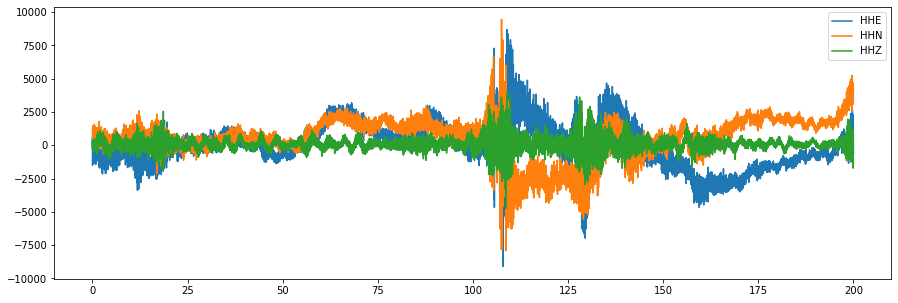

In [62]:
client = Client("Iris")
t = UTCDateTime('2018-10-01T09:42:17.906000Z')
stream = client.get_waveforms(network="XO", station="ET19", location="*", channel="HH?", starttime=t-100, endtime=t+100)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()

In [63]:
annotations = model.annotate(stream)
print(annotations)

3 Trace(s) in Stream:
XO.ET19..PhaseNet_P | 2018-10-01T09:40:37.909998Z - 2018-10-01T09:43:57.899998Z | 100.0 Hz, 20000 samples
XO.ET19..PhaseNet_S | 2018-10-01T09:40:37.909998Z - 2018-10-01T09:43:57.899998Z | 100.0 Hz, 20000 samples
XO.ET19..PhaseNet_N | 2018-10-01T09:40:37.909998Z - 2018-10-01T09:43:57.899998Z | 100.0 Hz, 20000 samples


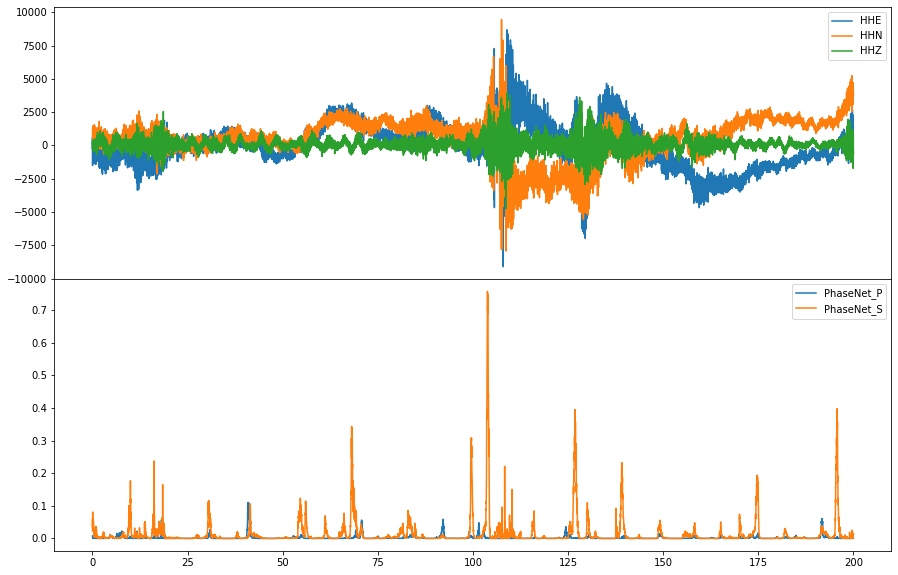

In [64]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In [61]:
picks = model.classify(stream, P_threshold=0.6, S_threshold=0.6)
print("Picks:")
for pick in picks:
    print(pick)

Picks:
AV.ANCK.	2018-10-01T09:42:21.348000Z	P
AV.ANCK.	2018-10-01T09:42:23.828000Z	S
